<a href="https://colab.research.google.com/github/manu123416/c2q_study/blob/master/Copy_of_Copy_of_Final_Project_Manu_V10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Student Name - Manu Chaudhary**

**Student ID - 3057422**

**Subject - PHSX911 "Introduction to Quantum Computation"**

**Session - Fall 2022**


## **Hybrid Quantum-Classical Neural Networks with PyTorch and Qiskit**

In this project, we explore how a classical neural network can be partially quantized to create a hybrid quantum-classical neural network [1]. We will code up a simple example that integrates Qiskit with a state-of-the-art open-source software package - PyTorch. 
The purpose of this project is to demonstrate the ease of integrating Qiskit with existing ML tools.

## **Contents**
* Basic Fundamentals
*   Construct the quantum circuit
*  Implement circuit as layer in Pytorch
*   Load MNIST data
*  Build our neural network
*   Run classification on MNIST data (0-1)








## **Basic Fundamentals**

### **How does it work?**
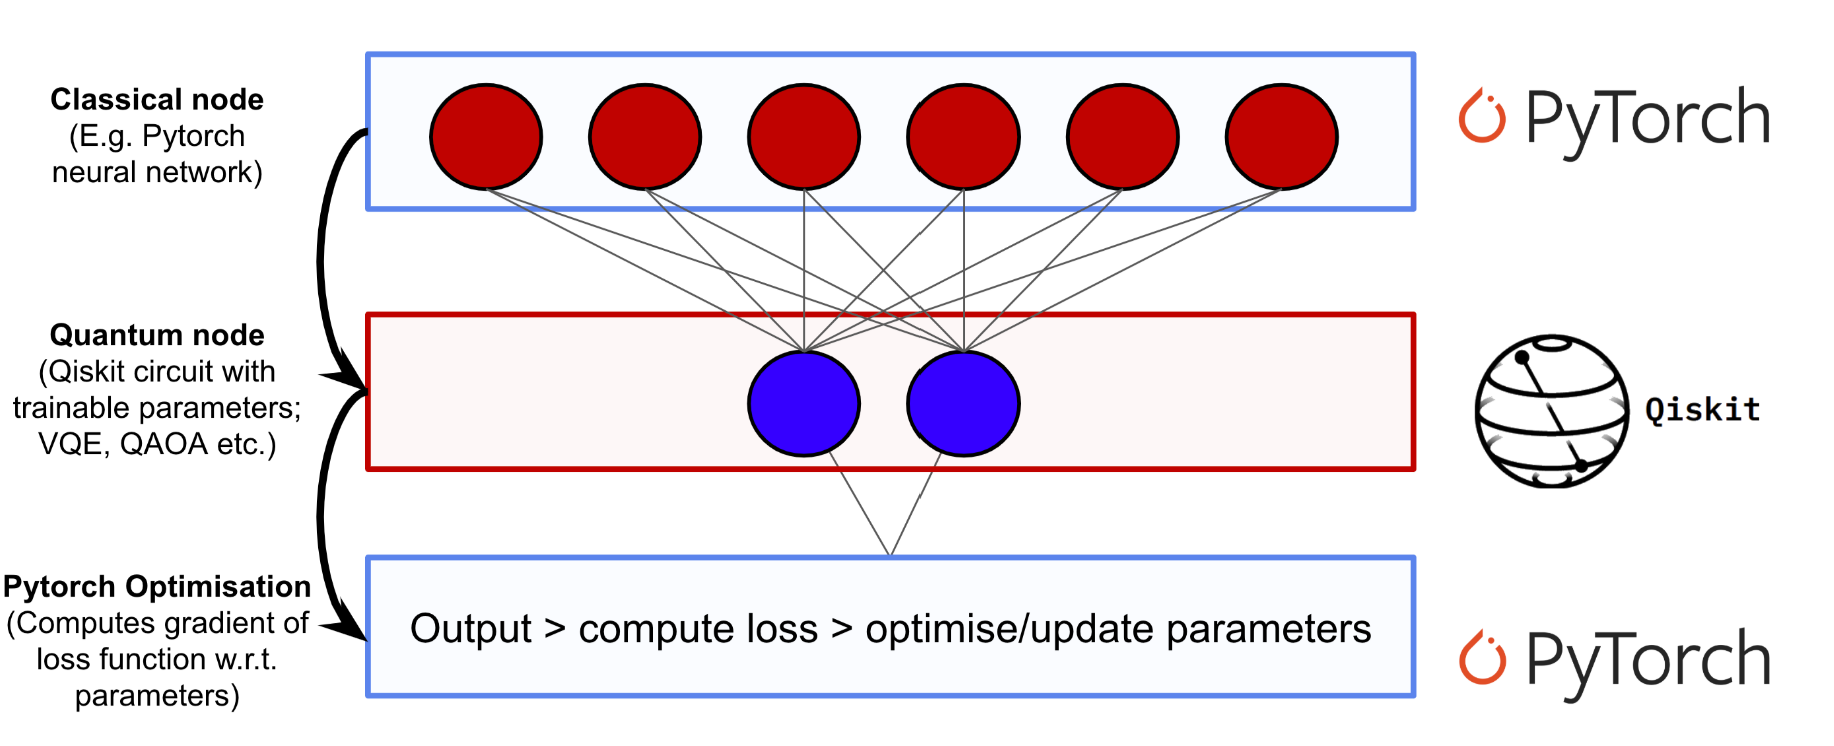
**Fig. 1** Illustrates the framework of the project

### **Some important definitions**


*   **Neuron** - A neuron is typically a simple, easy-to-compute, and nonlinear function that maps one or more inputs to a single real number. The single output of a neuron is typically copied and fed as input into other neurons. 

 Graphically, we represent neurons as nodes in a graph and we draw directed edges between nodes to indicate how the output of one neuron will be used as input to other neurons. 
It's also important to note that each edge in our graph is often associated with a scalar-value called a weight. The idea here is that each of the inputs to a neuron will be multiplied by a different scalar before being collected and processed into a single value. The objective when training a neural network consists primarily of choosing our weights such that the network behaves in a particular way.
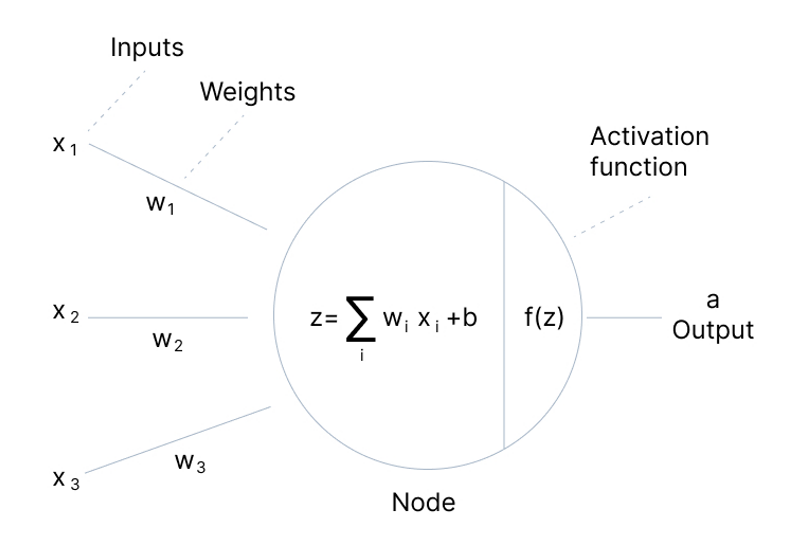


*   **Neurons Network** - A neural network is a network or circuit of biological neurons, or, in a modern sense, an artificial neural network, composed of artificial neurons or nodes. 




*   **Feed Forward Neural Networks** - It is also worth noting that the particular type of neural network we will concern ourselves with is called a feed-forward neural network (FFNN). 
This means that as data flows through our neural network, it will never return to a neuron it has already visited. 
Furthermore, we will stipulate that neurons within the same layer of our neural network will not have edges between them.
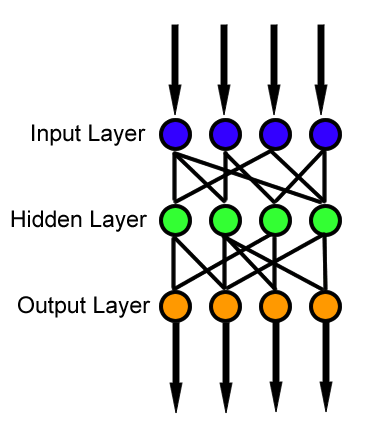





* **Backpropagation** - The practice of fine-tuning the weights of a neural network based on the error rate (i.e., loss) obtained in the previous epoch (i.e., iteration) to minimize the cost function. 






*   **IO Structure of Layers** - The input to a neural network is a classical (real-valued) vector. Each component of the input vector is multiplied by a different weight and fed into a layer of neurons according to the graph structure of the network. 
After each neuron in the layer has been evaluated, the results are collected into a new vector where the i'th component records the output of the i'th neuron. 
This new vector can then be treated as an input for a new layer, and so on. 
We will use the standard term **hidden layer** to describe all but the first and last layers of our network.



### **So How Does Quantum Enter the Picture?**

*   To create a quantum-classical neural network, one can implement a hidden layer for our neural network using a parameterized quantum circuit. 
By **"parameterized quantum circuit"**, we mean a quantum circuit where the rotation angles for each gate are specified by the components of a classical input vector. 

*   The outputs from our neural network's previous layer will be collected and used as the inputs for our parameterized circuit. 

*   The measurement statistics of our quantum circuit can then be collected and used as inputs for the following layer. A simple example is depicted below:






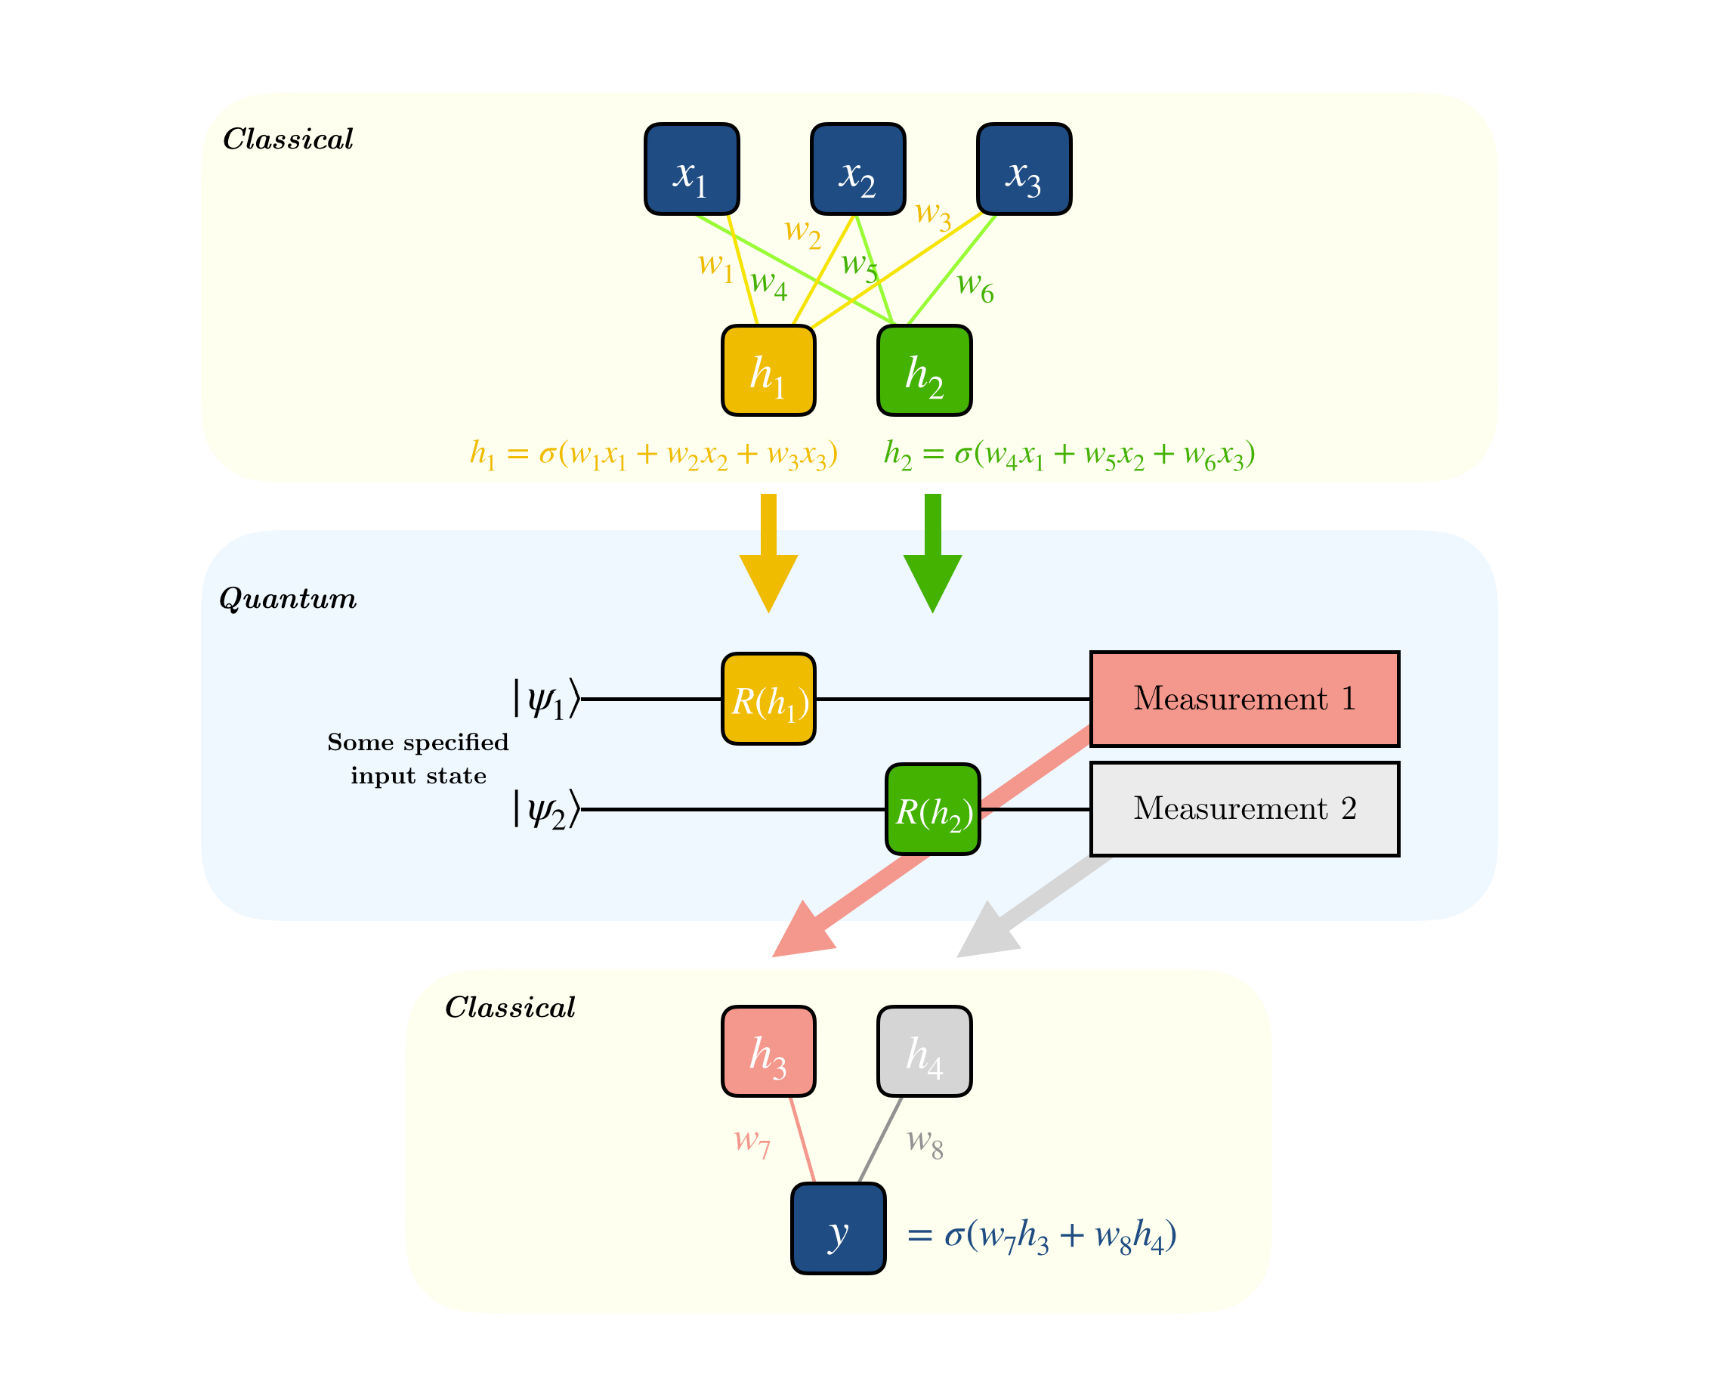

Here, $\sigma$ is a **Activation Function** and $h_i$ is the value of neuron $i$ at each hidden layer. $R(h_i)$ represents any rotation gate about an angle equal to $h_i$ and $y$ is the final prediction value generated from the hybrid network. 

### **What about backpropagation?**
*How do we calculate gradients when quantum circuits are involved?* 
This would be necessary to enlist powerful optimization techniques such as **gradient descent**[2]. 
In classical computing, the gradient descent is a first iterative optimization algorithm for finding a local minimum of a differentiable function.
In quantum computing, we can view a quantum circuit as a black box and the gradient of this black box with respect to its parameters can be calculated as follows: 
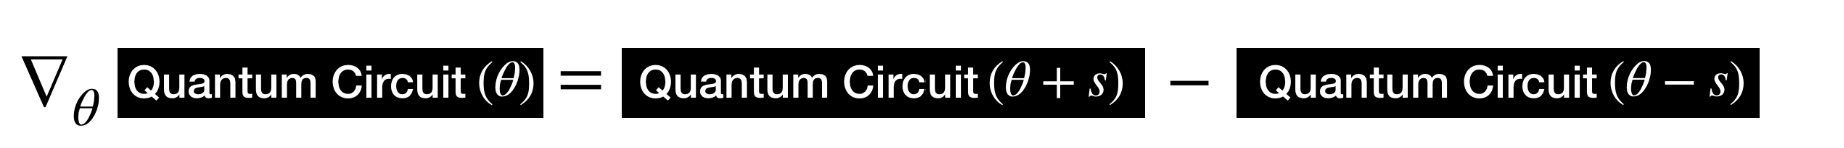

where $\theta$ represents the parameters of the quantum circuit and $s$ is a macroscopic shift. The gradient is then simply the difference between our quantum circuit evaluated at $\theta+s$ and $\theta - s$. Thus, we can systematically differentiate our quantum circuit as part of a larger backpropagation routine. This closed form rule for calculating the gradient of quantum circuit parameters is known as the **parameter shift rule** [3]

In [ ]:
! pip install qiskit
! pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import packages

In [ ]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

from qiskit import execute
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit import Aer
import qiskit

import numpy as np

from tqdm import tqdm

import itertools

from matplotlib import pyplot as plt

### Set Hyperparameters
Defining some hyperparameters that will be used in the quantum circuit and architecture for the neural netowrk in Pytorch.

In [ ]:
# Set Hyper parameters. Defining parameters that will be used in the quantum circuit and architecture of the Neural Network
np.random.seed = 42

N_QUBITS = 2

TOTAL_SHOTS = 10000 
EPS = 0.9 
MOMENTUM = 0.5           # The momentum value causes the optimizer to take slighly larger steps in the direction of of strongest improvement over last few steps

#****UNCOMMENT the Below Code if you want to use Hardware ****#
from qiskit import IBMQ
IBMQ.save_account('3916efce754d71288ced70245b4226bddebbb417fef0c00884099c10b53d1a3bf1ad7744c1f55da4ce6cfa362405ecd186d0e6ad80252f0c492916b8674b819f', overwrite=True)
IBMQ.load_account() 
provider=IBMQ.get_provider('ibm-q')
SIMULATOR= provider.get_backend('ibmq_lima')

#****COMMENT the BELOW Code Line is you want to use the Simulator ***#
# SIMULATOR = qiskit.Aer.get_backend('qasm_simulator')


### Construct the QuantumCircuit Class 
here we create a simple quantum circuit with number of qubits `N_QUBITS=2`. It has two quantum rotation parameters and two outputs.

In [ ]:


def to_num(tensor_list):  ## Testing
    numList = []
    for tensor in tensor_list:
        numList += [tensor.item()]
    return numList


class QiskitCircuit():
    def __init__(self, n_qubits, backend, shots):
        self.beta_val = Parameter('Beta')
        self.gamma_val = Parameter('Gamma')
        self.gamma_val1 = Parameter('Gamma')
        self.shots = shots

        def create_quantum_circuit():
            ckt = QuantumCircuit(2, 2)
            # ckt.h(0)
            # ckt.h(1)

            ckt.rx(self.beta_val, 0)
            ckt.rx(self.beta_val, 1)

            ckt.cx(0, 1)
            ckt.rz(-1 * self.gamma_val, 0)
            ckt.rz(-1 * self.gamma_val, 1)

            ckt.cx(0, 1)

            ckt.measure([0, 1], [0, 1])
            return ckt

        self.circuit = create_quantum_circuit()

    def energy_expectation(self, counts, shots, i, j, Cij=-1):  # calculate expectation for one qubit pair
        expects_val = 0
        for key in counts.keys():
            perc = counts[key] / shots
            check = Cij * (float(key[i]) - 1 / 2) * (float(key[j]) - 1 / 2) * perc
            expects_val += check

        return [expects_val]

    def bind(self, parameters):
        [self.beta_val, self.gamma_val,self.gamma_val1] = parameters
        self.circuit.data[0][0]._params = to_num(parameters)[0:1]
        self.circuit.data[1][0]._params = to_num(parameters)[0:1]
        self.circuit.data[3][0]._params = to_num(parameters)[1:2]
        self.circuit.data[4][0]._params = to_num(parameters)[2:3]

        return self.circuit

    def run(self, i):
        self.bind(i)  # Calling the bind function
        # Comment the below line if you want to use Hardware
        # backend = Aer.get_backend('qasm_simulator')

        # Uncomment the below two lines if you want to use the Hardware
        provider=IBMQ.get_provider('ibm-q')
        backend= provider.get_backend('ibmq_lima')
        job_sim = execute(self.circuit, backend, shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        energy_expect_value = self.energy_expectation(counts, self.shots, 0,
                                                      1)  ## Calling the function def energy_expectation

        return energy_expect_value

Expected value for rotation [pi/4]: [-0.12064999999999998]


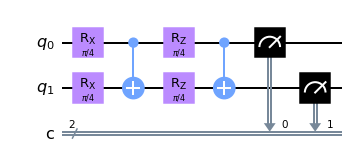

In [ ]:

circuit = QiskitCircuit(N_QUBITS, SIMULATOR, TOTAL_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*(N_QUBITS+1)))))
circuit.circuit.draw(output='mpl')


### Implement circuit as layer in Pytorch
Each layer in Pytorch has two basic functions: `forward` and `backward`. The first performs the layer's forward pass through the network, and the backward calculates the gradient (using a finite difference), which is used to update the previous layers' parameters.

In [ ]:

class TorchCircuit(Function):

    @staticmethod
    def forward(ctx, i):  # ctx is content argument
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(N_QUBITS, SIMULATOR, shots=TOTAL_SHOTS)

        exp_val = ctx.QiskitCirc.run(i)
        result_val = torch.tensor([exp_val])
        ctx.save_for_backward(result_val, i)

        return result_val

    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        for k in range(N_QUBITS+1):
            shifting_right = input_numbers.detach().clone()
            shifting_right[k] = shifting_right[k] + EPS
            shifting_left = input_numbers.detach().clone()
            shifting_left[k] = shifting_left[k] - EPS

            expectation_right = ctx.QiskitCirc.run(shifting_right)  # run function  called
            expectation_left = ctx.QiskitCirc.run(shifting_left)  # run function  called

            gradient_val = torch.tensor([expectation_right]) - torch.tensor(
                [expectation_left]) * 2  # gradient function called

            gradients = torch.cat((gradients, gradient_val.float()))  # Using a torch concatenate the gradient

        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T

### Test the Quantum Circuit's Gradient Descent
Using a toy example to test the gradient descent, we want the "neural net" consisting of just the quantum circuit and a linear layer to converge to an optimal set of parameters. If the gradient descent works, we should see that the loss eventually goes down.

100%|██████████| 1/1 [10:09<00:00, 609.47s/it]


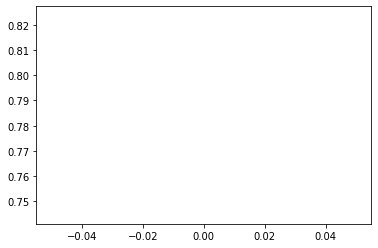

In [ ]:

qc_obj = TorchCircuit.apply

def cost(y):
    target_val = -1
    exp_val = qc_obj(y)[0]
    val = exp_val
    return torch.abs(val - target_val) ** 2, exp_val

y = torch.tensor([-np.pi/4]*(N_QUBITS+1), requires_grad=True)
opt = torch.optim.Adam([y], lr=0.1)

num_epoch = 1    # changed to 1 from 100

lossList = []
expvalList = []     # This contains all the val returned from forward function

for i in tqdm(range(num_epoch)):                            # tqdm is for displaying bar
    opt.zero_grad()
    loss, expval = cost(y)
    loss.backward()
    opt.step()
    lossList.append(loss.item())
    expvalList.append(expval)

plt.plot(lossList)

### Load MNIST (0-1) Data
We will now load 200 samples of each class (0 and 1) from MNIST to use as training data and the same amounts for the testing data.

**Training Data**

In [ ]:
# Training Data
num_samples = 4 # It will take out 40 zeros and 40 ones

train_data = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1
index = np.append(np.where(train_data.targets == 0)[0][:num_samples],
                np.where(train_data.targets == 1)[0][:num_samples])

train_data.data = train_data.data[index]
train_data.targets = train_data.targets[index]

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, pin_memory=True)

**Examine the training data**

In [ ]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

**View the Image**

Matplotlib can interpret pixel values through a variety of colormaps

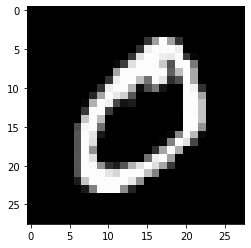

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)),cmap="gray")

**Testing Data**

In [ ]:

# Testing Data
num_samples = 4   # Changed from 200

test_data = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

index = np.append(np.where(test_data.targets == 0)[0][:num_samples],
                np.where(test_data.targets == 1)[0][:num_samples])

test_data.data = test_data.data[index]
test_data.targets = test_data.targets[index]

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# batch_size= 1 means feeding 1 data sample at a time

### **Build our neural network with the quantum layer**
Using the TorchCircuit we can define the structure of the NN. The overall structure consists of convolutional layers, linear layers, the quantum layer, and an output linear layer.

In [ ]:
auxilaryVar = 3


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10,
                               kernel_size=5)  ## 2D convolution layer. Number of channels in the input image= 1, Number of channels produced by the convolution= 10, kernel size = 5 means 5*5 window size
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  # This is for preventing overfitting
        self.fc1 = nn.Linear(in_features=320, out_features=50,
                             bias=True)  ##  y= xA^T + b. x= inputs, A= weights, b= bias. If bias is false, then it is kept as 0
        self.fc2 = nn.Linear(in_features=50, out_features=N_QUBITS * auxilaryVar * 4,
                             bias=True)  # out_feautures= 2*3*2= 12
        self.fc3 = nn.Linear(N_QUBITS , auxilaryVar) # not using it
        self.qc_obj = TorchCircuit.apply
        self.out = nn.Linear(auxilaryVar+1, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # relu is an Activation Function
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        x = torch.tanh(x)  ## tanh(x) is an Activation funtion
        x = x.view(-1)
        # print(x.shape)
        x = torch.cat([(x[i * 2: i * 2 + 2]) / torch.norm(x[i * 2: i * 2 + 2]) for i in range(auxilaryVar * 4)],
                      dim=-1)  # normalize sin and cos for each angle

        x = torch.stack([torch.atan2(x[i * 2], x[i * 2 + 1]) for i in range(
            auxilaryVar * 4)])  # converting to angles. Mathematically it can also be termed as a 2-argument arctangent (atan2)

        x = torch.cat([qc_obj(x[3*i : 3*i + 3]) for i in range(auxilaryVar+1)], dim=1)  # Quantum layer


        x = self.out(x)
        return F.log_softmax(x)  # This returns the prediction

    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)


In [ ]:
network = Net()
print(network)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.6)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=24, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
  (out): Linear(in_features=4, out_features=2, bias=True)
)


### **Run training with 5 epochs**

In [ ]:
# Run training with 5 epochs
epochs = 1 # Changed from 5 to 1
lossList = []
lossFunc = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        optimizer.zero_grad()  # Zero the gradient somehow get the benefit of batch training
        # Forward pass
        output = network(data)  # This will call the forward function of Net class
        # Calculating loss
        loss = lossFunc(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())

    lossList.append(sum(total_loss) / len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, lossList[-1]))

  0%|          | 0/8 [00:00<?, ?it/s]WARNING:websocket:websocket connected
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
ERROR:websocket:Connection to remote host was lost. - goodbye
 75%|███████▌  | 6/8 [4:20:21<1:38:41, 2960.61s/it]WARNING:websocket:websocket connected
ERROR:websocket:[Errno -5] No address associated with hostname - goodbye
 88%|████████▊ | 7/8 [4:57:21<45:18, 2718.31s/it]  WARNING:websocket:websocket connected
ERROR:websocket:[Errno -5] No address associated with hostname - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
100%|██████████| 8/8 [6:39:51<00:00, 2998.98s/it]

Training [100%]	Loss: 0.7187


Text(0, 0.5, 'Cross Entropy Loss')

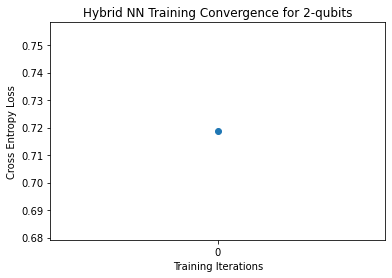

In [ ]:
plt.plot(lossList, 'o')
plt.xticks(range(epochs))
plt.title('Hybrid NN Training Convergence for {}-qubits'.format(N_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

**Calculate test accuracy**

In [ ]:
accuracy = 0
number = 0
for batch_index, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

  0%|          | 0/8 [00:00<?, ?it/s]WARNING:websocket:websocket connected
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|██████████| 8/8 [44:31<00:00, 333.95s/it]


In [ ]:
print("Performance on test data: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    

Performance on test data: 4/8 = 50.0%


**View some sample predictions**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


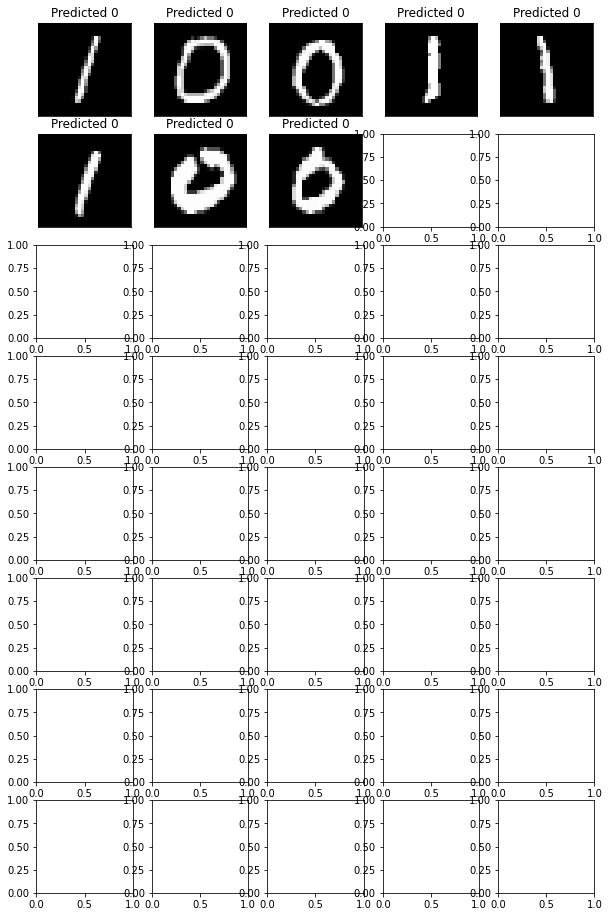

In [ ]:
n_samples = (8, 5)
index = 0
fig, axes = plt.subplots(nrows=n_samples[0], ncols=n_samples[1], figsize=(10, 2*n_samples[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if index == n_samples[0]*n_samples[1]:
            break
        pred = network.predict(data).item()

        axes[index//n_samples[1]][index%n_samples[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[index//n_samples[1]][index%n_samples[1]].set_xticks([])
        axes[index//n_samples[1]][index%n_samples[1]].set_yticks([])
        axes[index//n_samples[1]][index%n_samples[1]].set_title('Predicted {}'.format(pred))
        
        index += 1

## **Conclusion**
In the experiment, we saw that the hybrid quantum neural networks performed well in differentiating 0 and 1 in the MNIST dataset with very high accuracy.

## **References**

[1] https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html

[2] https://en.wikipedia.org/wiki/Gradient_descent

[3] Crooks, Gavin E. "Gradients of parameterized quantum gates using the parameter-shift rule and gate decomposition." arXiv preprint arXiv:1905.13311 (2019).
